In [1]:
print("Let's check the structure of Sinergym environment now.")

Let's check the structure of Sinergym environment now.


In [5]:
# ============================================================================
# CELL 0 : SETUP - À EXÉCUTER EN PREMIER
# ============================================================================

import os
import sys
from pathlib import Path

os.chdir('/workspaces/energy-rl-project')
sys.path.insert(0, '/workspaces/energy-rl-project/src')

# Configuration EnergyPlus
os.environ['EPLUS_PATH'] = '/usr/local/EnergyPlus-24-2-0'

# Imports standards
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import warnings
warnings.filterwarnings('ignore')

# Imports projet
from src.config import DATA_RAW_DIR, DATA_OFFLINE_DIR, RESULTS_LOGS_DIR, RESULTS_FIGURES_DIR
from src.environments import BuildingBatteryEnv

print("✅ Setup terminé")
print(f"   Working dir: {os.getcwd()}")
print(f"   Data raw: {DATA_RAW_DIR}")

✅ Setup terminé
   Working dir: /workspaces/energy-rl-project
   Data raw: /workspaces/energy-rl-project/data/raw


In [6]:
# ============================================================================
# CELL 1 : VÉRIFICATION DES CHEMINS
# ============================================================================

%matplotlib inline

import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import warnings
warnings.filterwarnings('ignore')

from src.config import DATA_RAW_DIR, DATA_OFFLINE_DIR, RESULTS_LOGS_DIR, RESULTS_FIGURES_DIR
from src.environments import BuildingBatteryEnv
import sinergym

print("=" * 70)
print("🔧 VÉRIFICATION DES CHEMINS")
print("=" * 70)

# Vérifier EPLUS_PATH
if os.path.isdir(os.environ['EPLUS_PATH']):
    print(f"✅ EPLUS_PATH : {os.environ['EPLUS_PATH']}")
else:
    print(f"❌ EPLUS_PATH INVALIDE")
    sys.exit(1)

# Vérifier Energy+.idd
energy_idd = os.path.join(os.environ['EPLUS_PATH'], 'Energy+.idd')
if os.path.exists(energy_idd):
    print(f"✅ Energy+.idd trouvé")
else:
    print(f"❌ Energy+.idd NOT FOUND")
    sys.exit(1)

# Vérifier libenergyplusapi.so
libenergy = os.path.join(os.environ['EPLUS_PATH'], 'libenergyplusapi.so')
if os.path.exists(libenergy):
    print(f"✅ libenergyplusapi.so trouvé")
else:
    print(f"❌ libenergyplusapi.so NOT FOUND")
    sys.exit(1)

print(f"\n✅ Sinergym version: {sinergym.__version__}")
print(f"✅ Python version: {sys.version.split()[0]}")
print(f"✅ BuildingBatteryEnv importé avec succès")
print("\n" + "=" * 70)

🔧 VÉRIFICATION DES CHEMINS
✅ EPLUS_PATH : /usr/local/EnergyPlus-24-2-0
✅ Energy+.idd trouvé
✅ libenergyplusapi.so trouvé

✅ Sinergym version: 3.10.0
✅ Python version: 3.12.3
✅ BuildingBatteryEnv importé avec succès



In [15]:
# ============================================================================
# CELL 2 : DIAGNOSTIC SINERGYM + CLEANUP À LA FIN
# ============================================================================

from src.config import RESULTS_LOGS_DIR
import shutil
from pathlib import Path

output_file = str(RESULTS_LOGS_DIR / 'diagnostic_sinergym.txt')

print("=" * 70)
print("🔍 DIAGNOSTIC : Structure de Sinergym")
print("=" * 70 + "\n")

# === CRÉER L'ENV DE BASE ===
print("📍 Étape 1 : Créer l'environnement Sinergym...")
base_env_id = 'Eplus-5zone-hot-continuous-v1'

try:
    base_env = gym.make(base_env_id)
    print(f"✅ Env créé : {base_env_id}\n")
except Exception as e:
    print(f"❌ ERREUR lors de la création : {e}")
    import traceback
    traceback.print_exc()
    sys.exit(1)

# === AFFICHER LES ESPACES ===
print(f"📊 ESPACES :")
print(f"   Observation space : {base_env.observation_space}")
print(f"   Action space      : {base_env.action_space}\n")

# === RESET ===
print("📍 Étape 2 : Reset de l'environnement...")
try:
    obs, info = base_env.reset()
    print(f"✅ Reset réussi\n")
except Exception as e:
    print(f"❌ ERREUR lors du reset : {e}")
    import traceback
    traceback.print_exc()
    sys.exit(1)

# === AFFICHER L'OBSERVATION ===
print(f"📊 OBSERVATION BRUTE :")
print(f"   Shape : {obs.shape}")
print(f"   Type  : {type(obs)}")
print(f"   Dtype : {obs.dtype}\n")

print(f"📋 CONTENU DE L'OBSERVATION (tous les indices) :\n")
obs_lines = []
for i, val in enumerate(obs):
    line = f"   obs[{i:2d}] = {val:15.6f}"
    print(line)
    obs_lines.append(line)

# === AFFICHER LE DICTIONNAIRE INFO ===
print(f"\n📌 CONTENU DU DICTIONNAIRE 'INFO' :\n")
info_lines = []
for key in sorted(info.keys()):
    value = info[key]
    if isinstance(value, (int, float)):
        line = f"   {key:30s} = {value}"
        print(line)
        info_lines.append(line)
    else:
        line = f"   {key:30s} = {type(value).__name__}"
        print(line)
        info_lines.append(line)

# === TEST SUR PLUSIEURS TIMESTEPS ===
print(f"\n🔄 TEST SUR 3 TIMESTEPS :\n")
timestep_lines = []
for step_num in range(3):
    action = base_env.action_space.sample()
    obs, reward, terminated, truncated, info = base_env.step(action)
    
    line1 = f"Step {step_num + 1}:"
    line2 = f"   hour          = {info.get('hour', '❌ NOT FOUND')}"
    line3 = f"   month         = {info.get('month', '❌ NOT FOUND')}"
    line4 = f"   day           = {info.get('day', '❌ NOT FOUND')}"
    line5 = f"   timestep      = {info.get('timestep', '❌ NOT FOUND')}"
    line6 = f"   total_power_no_units = {info.get('total_power_no_units', '❌ NOT FOUND')}"
    line7 = f"   total_power   = {info.get('total_power', '❌ NOT FOUND')}"
    
    print(line1)
    print(line2)
    print(line3)
    print(line4)
    print(line5)
    print(line6)
    print(line7)
    print()
    
    timestep_lines.extend([line1, line2, line3, line4, line5, line6, line7, ""])

# ============================================================================
# 🔧 CLEANUP : DÉPLACER LES EPLUS VERS data/raw/
# ============================================================================

print("\n" + "=" * 70)
print("🔧 DÉPLACEMENT DES FICHIERS EPLUS VERS data/raw/")
print("=" * 70)

# Chercher les dossiers Eplus à la racine du projet (pas à /)
root_eplus_dirs = list(Path('/workspaces/energy-rl-project').glob('Eplus-*-res*'))

if root_eplus_dirs:
    print(f"\n⚠️ Trouvé {len(root_eplus_dirs)} dossier(s) à la racine du projet\n")
    for dir_path in root_eplus_dirs:
        try:
            dest = DATA_RAW_DIR / dir_path.name
            if dest.exists():
                print(f"   ⏩ {dir_path.name} (déjà existe)")
            else:
                shutil.move(str(dir_path), str(dest))
                print(f"   ✅ {dir_path.name} → data/raw/")
        except Exception as e:
            print(f"   ❌ {dir_path.name}: {e}")
else:
    print("\n✅ Aucun dossier à déplacer (déjà en data/raw/)")

print("\n" + "=" * 70)

# Fermer l'env
base_env.close()

print("\n✅ DIAGNOSTIC TERMINÉ")

# === SAUVEGARDER DANS UN FICHIER ===
with open(output_file, 'w') as f:
    f.write("=" * 70 + "\n")
    f.write("🔍 DIAGNOSTIC : Structure de Sinergym\n")
    f.write("=" * 70 + "\n\n")
    f.write("📋 OBSERVATION BRUTE :\n")
    for line in obs_lines:
        f.write(line + "\n")
    f.write("\n📌 DICTIONNAIRE 'INFO' :\n")
    for line in info_lines:
        f.write(line + "\n")
    f.write("\n🔄 TIMESTEPS :\n")
    for line in timestep_lines:
        f.write(line + "\n")

print(f"✅ Sortie sauvegardée dans : {output_file}")

🔍 DIAGNOSTIC : Structure de Sinergym

📍 Étape 1 : Créer l'environnement Sinergym...
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
✅ Env cré

In [16]:
# ============================================================================
# CELL 3 : WRAPPING AVEC BUILDINGBATTERYENV
# ============================================================================

print("🔋 Wrapping avec BuildingBatteryEnv...")

wrapped_env = BuildingBatteryEnv(
    env=base_env,
    battery_capacity=10.0,
    battery_efficiency=0.9,
    battery_power_max=5.0,
    soc_min=0.2,
    soc_max=0.9,
    pv_max_power=5.0,
    pv_efficiency=0.2,
    price_on_peak=0.25,
    price_off_peak=0.10,
    comfort_temp_range=(21.0, 25.0),
    lambda_comfort=1.0,
    lambda_battery=0.1
)

print("✅ Wrapper appliqué")

🔋 Wrapping avec BuildingBatteryEnv...
✅ Wrapper appliqué


In [17]:
# ============================================================================
# CELL 4 : TEST RESET()
# ============================================================================

print("🔄 Test de reset()...")

obs, info = wrapped_env.reset()

print("✅ Reset réussi")
print(f"   Observation shape: {obs.shape}")
print(f"   Observation (premiers 5 éléments): {obs[:5]}")
print(f"   Observation (dernier élément = SOC): {obs[-1]:.3f} (devrait être 0.5 = 50%)")
print(f"   Info keys: {list(info.keys())}")
print(f"   SOC après reset: {wrapped_env.soc * 100:.1f}%")

🔄 Test de reset()...
#----------------------------------------------------------------------------------------------#   
[ENVIRONMENT] (INFO) : Starting a new episode.                                       
[ENVIRONMENT] (INFO) : Episode 2: Eplus-5zone-hot-continuous-v1                      
#----------------------------------------------------------------------------------------------# 
[MODEL] (INFO) : Episode directory created.                                          
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.         
[MODEL] (INFO) : Adapting weather to building model.                                 
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-2/output.
Simulation Progress [Episode 1]: 100%|██████████| 100/100 [00:28<00:00,  3.55%/s, 100% completed]
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 2 start

In [18]:
# ============================================================================
# CELL 5 : TEST STEP() - 5 ACTIONS ALÉATOIRES
# ============================================================================

print("🎮 Test de step() avec 5 actions aléatoires...")
print()

for i in range(5):
    action = wrapped_env.action_space.sample()
    
    hvac_action = action[:-1]
    battery_action = action[-1]
    
    print(f"Step {i+1}:")
    print(f"  Action HVAC: {hvac_action}")
    print(f"  Action Battery (normalized): {battery_action:.3f}")
    
    obs, reward, terminated, truncated, info = wrapped_env.step(action)
    
    print(f"  → SOC: {info['soc']*100:.1f}%")
    print(f"  → Battery Power: {info['battery_power']:.3f} kW")
    print(f"  → PV Power: {info['pv_power']:.3f} kW")
    print(f"  → Electricity Price: {info['electricity_price']:.3f} €/kWh")
    print(f"  → Reward: {reward:.3f}")
    print(f"  → Reward components: Cost={info['reward_components']['cost']:.3f}, "
          f"Comfort={info['reward_components']['comfort']:.3f}, "
          f"Battery={info['reward_components']['battery']:.3f}")
    print()
    
    if terminated or truncated:
        print("Episode terminé")
        break

print("✅ Tests de step() réussis")

🎮 Test de step() avec 5 actions aléatoires...

Step 1:
  Action HVAC: [18.555632 24.051025]
  Action Battery (normalized): 0.159
  → SOC: 50.0%
  → Battery Power: 0.714 kW
  → PV Power: 0.000 kW
  → Electricity Price: 0.100 €/kWh
  → Reward: -1.538
  → Reward components: Cost=-0.058, Comfort=-1.481, Battery=-0.000

Step 2:
  Action HVAC: [12.9547415 29.797293 ]
  Action Battery (normalized): -0.422
  → SOC: 50.0%
  → Battery Power: -2.345 kW
  → PV Power: 0.000 kW
  → Electricity Price: 0.100 €/kWh
  → Reward: -1.766
  → Reward components: Cost=-0.003, Comfort=-1.763, Battery=-0.000

Step 3:
  Action HVAC: [22.335361 25.675789]
  Action Battery (normalized): 0.496
  → SOC: 50.0%
  → Battery Power: 2.232 kW
  → PV Power: 0.000 kW
  → Electricity Price: 0.100 €/kWh
  → Reward: -0.636
  → Reward components: Cost=-0.242, Comfort=-0.394, Battery=-0.000

Step 4:
  Action HVAC: [12.313326 27.770754]
  Action Battery (normalized): -0.422
  → SOC: 50.0%
  → Battery Power: -2.347 kW
  → PV Power

📊 Exécution d'un épisode et visualisation du SOC...
#----------------------------------------------------------------------------------------------#      
[ENVIRONMENT] (INFO) : Starting a new episode.                                         
[ENVIRONMENT] (INFO) : Episode 3: Eplus-5zone-hot-continuous-v1                        
#----------------------------------------------------------------------------------------------#   
[MODEL] (INFO) : Episode directory created.                                            
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.           
[MODEL] (INFO) : Adapting weather to building model.                                  
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-3/output.
Simulation Progress [Episode 2]: 100%|██████████| 100/100 [00:00<00:00, 139.84%/s, 100% completed]

Simulation Progress [Episode 2]: 100%|██████████| 100/100 [00:09<00:00, 10.21%/s, 100% completed] 
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 3 started.
Simulation Progress [Episode 3]:   2%|▏         | 2/100 [00:00<00:00, 1810.23%/s, 2% completed] ✅ 101 steps exécutés


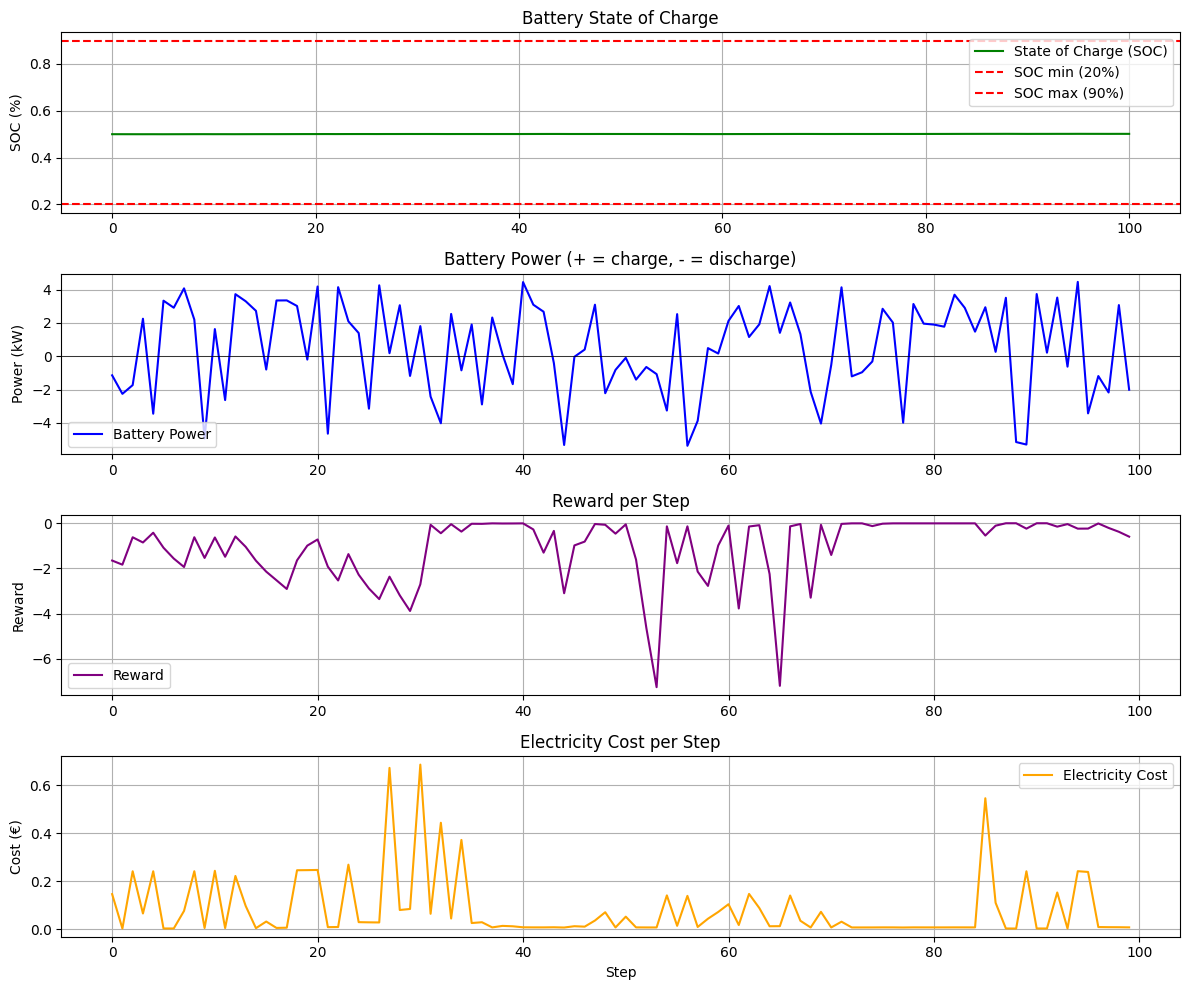

✅ Visualisation terminée

🔧 DÉPLACEMENT DES FICHIERS EPLUS CRÉÉS VERS data/raw/

⚠️ Trouvé 1 dossier(s) à déplacer

   ⏩ Eplus-5zone-hot-continuous-v1-res1 (déjà existe)



In [19]:
# ============================================================================
# CELL 6 : EXÉCUTION D'UN ÉPISODE ET VISUALISATION DU SOC
# ============================================================================

print("📊 Exécution d'un épisode et visualisation du SOC...")

obs, info = wrapped_env.reset()

soc_history = [wrapped_env.soc]
battery_power_history = []
reward_history = []
cost_history = []

max_steps = 100
for step in range(max_steps):
    action = wrapped_env.action_space.sample()
    obs, reward, terminated, truncated, info = wrapped_env.step(action)
    
    soc_history.append(info['soc'])
    battery_power_history.append(info['battery_power'])
    reward_history.append(reward)
    cost_history.append(info['electricity_cost'])
    
    if terminated or truncated:
        print(f"Episode terminé après {step+1} steps")
        break

print(f"✅ {len(soc_history)} steps exécutés")

# Tracer les résultats
fig, axes = plt.subplots(4, 1, figsize=(12, 10))

# SOC
axes[0].plot(soc_history, label='State of Charge (SOC)', color='green')
axes[0].axhline(y=0.2, color='r', linestyle='--', label='SOC min (20%)')
axes[0].axhline(y=0.9, color='r', linestyle='--', label='SOC max (90%)')
axes[0].set_ylabel('SOC (%)')
axes[0].set_title('Battery State of Charge')
axes[0].legend()
axes[0].grid(True)

# Battery Power
axes[1].plot(battery_power_history, label='Battery Power', color='blue')
axes[1].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[1].set_ylabel('Power (kW)')
axes[1].set_title('Battery Power (+ = charge, - = discharge)')
axes[1].legend()
axes[1].grid(True)

# Reward
axes[2].plot(reward_history, label='Reward', color='purple')
axes[2].set_ylabel('Reward')
axes[2].set_title('Reward per Step')
axes[2].legend()
axes[2].grid(True)

# Cost
axes[3].plot(cost_history, label='Electricity Cost', color='orange')
axes[3].set_ylabel('Cost (€)')
axes[3].set_xlabel('Step')
axes[3].set_title('Electricity Cost per Step')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()

print("✅ Visualisation terminée")

# ============================================================================
# 🔧 CLEANUP : DÉPLACER LES EPLUS CRÉÉS EN CELL 6 VERS data/raw/
# ============================================================================

print("\n" + "=" * 70)
print("🔧 DÉPLACEMENT DES FICHIERS EPLUS CRÉÉS VERS data/raw/")
print("=" * 70)

root_eplus_dirs = list(Path('/workspaces/energy-rl-project').glob('Eplus-*-res*'))

if root_eplus_dirs:
    print(f"\n⚠️ Trouvé {len(root_eplus_dirs)} dossier(s) à déplacer\n")
    for dir_path in root_eplus_dirs:
        try:
            dest = DATA_RAW_DIR / dir_path.name
            if dest.exists():
                print(f"   ⏩ {dir_path.name} (déjà existe)")
            else:
                shutil.move(str(dir_path), str(dest))
                print(f"   ✅ {dir_path.name} → data/raw/")
        except Exception as e:
            print(f"   ❌ {dir_path.name}: {e}")
else:
    print("\n✅ Aucun dossier à déplacer")

print("\n" + "=" * 70)

In [20]:
# ============================================================================
# CELL 7 : VÉRIFICATIONS FINALES
# ============================================================================

print("🔍 Vérifications finales...")
print()

obs, info = wrapped_env.reset()
print(f"✅ Observation shape: {obs.shape} (base + 1 pour SOC)")
print(f"✅ Action shape: {wrapped_env.action_space.shape} (base + 1 pour batterie)")
print()

print(f"✅ SOC après reset: {wrapped_env.soc*100:.1f}% (devrait être 50%)")
print(f"✅ SOC min configuré: {wrapped_env.soc_min*100:.1f}%")
print(f"✅ SOC max configuré: {wrapped_env.soc_max*100:.1f}%")
print()

print(f"✅ Dernier élément de obs: {obs[-1]:.3f}")
print(f"✅ wrapped_env.soc: {wrapped_env.soc:.3f}")
print(f"✅ Match: {np.isclose(obs[-1], wrapped_env.soc)}")
print()

print("✅ TOUS LES TESTS PASSENT !")
print("Le wrapper BuildingBatteryEnv fonctionne correctement.")

# ============================================================================
# 🔧 CLEANUP : DÉPLACER LES EPLUS CRÉÉS EN CELL 7 VERS data/raw/
# ============================================================================

print("\n" + "=" * 70)
print("🔧 DÉPLACEMENT DES FICHIERS EPLUS CRÉÉS VERS data/raw/")
print("=" * 70)

root_eplus_dirs = list(Path('/workspaces/energy-rl-project').glob('Eplus-*-res*'))

if root_eplus_dirs:
    print(f"\n⚠️ Trouvé {len(root_eplus_dirs)} dossier(s) à déplacer\n")
    for dir_path in root_eplus_dirs:
        try:
            dest = DATA_RAW_DIR / dir_path.name
            if dest.exists():
                print(f"   ⏩ {dir_path.name} (déjà existe)")
            else:
                shutil.move(str(dir_path), str(dest))
                print(f"   ✅ {dir_path.name} → data/raw/")
        except Exception as e:
            print(f"   ❌ {dir_path.name}: {e}")
else:
    print("\n✅ Aucun dossier à déplacer")

print("\n" + "=" * 70)

🔍 Vérifications finales...

Simulation Progress [Episode 3]:   2%|▏         | 2/100 [00:02<01:51,  1.14s/%, 2% completed]  
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 4: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-4/output.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 4 started.
✅ Observation shape: (18,) (base + 1 pour SOC)
✅ Action shape: (3,) (base + 1 pour batterie)

✅ SOC après reset: 50.0% (devrait être 50%)
✅ 

In [21]:
# ============================================================================
# CELL 8 : VISUALISATION DES BÂTIMENTS DISPONIBLES
# ============================================================================

print("🏢 Découverte des Bâtiments Disponibles dans Sinergym\n")

available_envs = [
    'Eplus-5zone-hot-continuous-v1',
    'Eplus-5zone-cool-continuous-v1',
    'Eplus-5zone-mixed-continuous-v1',
    'Eplus-office-hot-continuous-v1',
    'Eplus-office-cool-continuous-v1',
    'Eplus-datacenter-hot-continuous-v1',
    'Eplus-datacenter-cool-continuous-v1',
]

print("📋 Bâtiments Disponibles :\n")
buildings_info = {}

for env_id in available_envs:
    try:
        test_env = gym.make(env_id)
        obs_space = test_env.observation_space
        act_space = test_env.action_space
        
        buildings_info[env_id] = {
            'obs_shape': obs_space.shape[0],
            'act_shape': act_space.shape[0],
            'obs_range': (obs_space.low.min(), obs_space.high.max()),
            'act_range': (act_space.low.min(), act_space.high.max())
        }
        
        print(f"✅ {env_id}")
        print(f"   Observations: {obs_space.shape[0]} dims")
        print(f"   Actions: {act_space.shape[0]} dims")
        print(f"   Action range: [{act_space.low[0]:.1f}, {act_space.high[0]:.1f}]")
        print()
        
        test_env.close()
    except Exception as e:
        print(f"❌ {env_id} : {str(e)[:50]}")
        print()

# === TABLEAU RÉCAPITULATIF ===
print("\n" + "=" * 70)
print("📊 TABLEAU RÉCAPITULATIF")
print("=" * 70 + "\n")

df = pd.DataFrame({
    'Bâtiment': list(buildings_info.keys()),
    'Obs Dim': [v['obs_shape'] for v in buildings_info.values()],
    'Act Dim': [v['act_shape'] for v in buildings_info.values()],
    'Obs Min': [v['obs_range'][0] for v in buildings_info.values()],
    'Obs Max': [v['obs_range'][1] for v in buildings_info.values()],
})

print(df.to_string(index=False))

print("\n" + "=" * 70)
print(f"✅ {len(buildings_info)} bâtiments disponibles")
print("=" * 70)

# ============================================================================
# 🔧 CLEANUP FINAL : DÉPLACER TOUS LES EPLUS VERS data/raw/
# ============================================================================

print("\n" + "=" * 70)
print("🔧 CLEANUP FINAL : DÉPLACEMENT DE TOUS LES EPLUS VERS data/raw/")
print("=" * 70)

root_eplus_dirs = list(Path('/workspaces/energy-rl-project').glob('Eplus-*-res*'))

if root_eplus_dirs:
    print(f"\n⚠️ Trouvé {len(root_eplus_dirs)} dossier(s) à déplacer\n")
    for dir_path in root_eplus_dirs:
        try:
            dest = DATA_RAW_DIR / dir_path.name
            if dest.exists():
                print(f"   ⏩ {dir_path.name} (déjà existe)")
            else:
                shutil.move(str(dir_path), str(dest))
                print(f"   ✅ {dir_path.name} → data/raw/")
        except Exception as e:
            print(f"   ❌ {dir_path.name}: {e}")
else:
    print("\n✅ Aucun dossier à déplacer")

print("\n" + "=" * 70)
print("✅ PHASE 2 TERMINÉE - Tous les fichiers Eplus sont en data/raw/")
print("=" * 70)

🏢 Découverte des Bâtiments Disponibles dans Sinergym

📋 Bâtiments Disponibles :

#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res2
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
✅ Eplus-5zone-hot-continuous-v1
   Observations: 17 dims
   Actions: 2 dims
   Action range: [12.0, 23.2]

[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#======